# Importing dataset

In [78]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [79]:
# !kaggle datasets download -d hijest/genre-classification-dataset-imdb

In [80]:
# !unzip genre-classification-dataset-imdb.zip

# Data Preprocessing

In [81]:
import pandas as pd

In [82]:
train_data = pd.read_csv('Genre Classification Dataset/train_data.txt', delimiter = ":::",engine = 'python', names=['Title','Genre','Description'])
test_data = pd.read_csv('Genre Classification Dataset/test_data.txt', delimiter = ":::",engine = 'python', names=['Title','Genre','Description'])
test_data_soln = pd.read_csv('Genre Classification Dataset/test_data_solution.txt', delimiter = ":::",engine = 'python', names=['Title','Genre','Description'])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [83]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None


In [84]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [85]:
test_data.head()

,Title,Genre,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [86]:
test_data_soln.head()

,Title,Genre,Description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


# Data Visualization

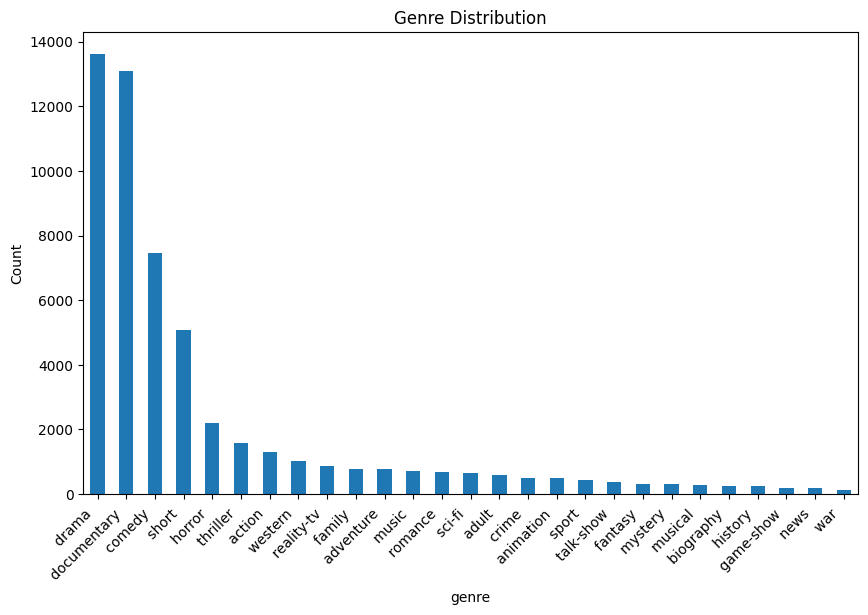

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
genre_counts = train_data["Genre"].value_counts()
genre_counts.plot(kind="bar")
plt.xlabel("genre")
plt.ylabel("Count")
plt.title("Genre Distribution")
plt.xticks(rotation=45, ha='right')
plt.show()

<Axes: xlabel='count', ylabel='Genre'>

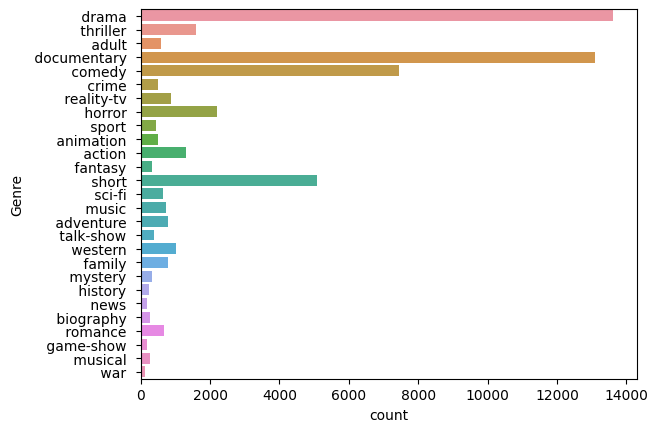

In [88]:
import seaborn as sns
sns.countplot(y='Genre',data=train_data)

# Data Cleaning

In [89]:
import re
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer as ps
corpus = []

def clean_desc(text):
    text = text.lower()
    text = re.sub('-',' ',text.lower())
    text = re.sub(f'[{string.digits}]',' ',text)
    return re.sub(f'[{re.escape(string.punctuation)}]','',text)
    text = ' '.join([ps.stem(word) for word in text.split() if word not in stopwords])
    text = ' '.join(text)
    corpus.append(text)

In [90]:
train_data['Cleaned_Desc'] = train_data.Description.apply(clean_desc)
test_data['Cleaned_Desc'] = test_data.Description.apply(clean_desc)
train_data['Cleaned_Desc_length'] = train_data['Cleaned_Desc'].apply(lambda x:len(x))
train_data.head()

,Title,Genre,Description,Cleaned_Desc,Cleaned_Desc_length
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening in to a conversation between his do...,533
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,a brother and sister with a past incestuous r...,182
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,as the bus empties the students for their fie...,633
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,to help their unemployed father make ends mee...,1057
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,the films title refers not only to the un rec...,614


# Tokenization

In [91]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [92]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['Cleaned_Desc'].values)

# Vectorization TF-IDF

In [93]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [94]:
X = tokenizer.texts_to_sequences(train_data['Cleaned_Desc'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_data['Genre']).values

X_test = tokenizer.texts_to_sequences(test_data['Cleaned_Desc'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_data_soln['Genre']).values

# Model building and Training

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [106]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
my_callbacks  = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, mode='auto')]

In [108]:
history = model.fit(X, y, epochs=6, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

Epoch 1/6
1695/1695 [==============================] - 672s 395ms/step - loss: 2.0203 - accuracy: 0.4147 - val_loss: 1.6687 - val_accuracy: 0.5102
Epoch 2/6
1695/1695 [==============================] - 671s 396ms/step - loss: 1.5800 - accuracy: 0.5427 - val_loss: 1.2781 - val_accuracy: 0.6330
Epoch 3/6
1695/1695 [==============================] - 669s 395ms/step - loss: 1.2467 - accuracy: 0.6407 - val_loss: 0.9224 - val_accuracy: 0.7444
Epoch 4/6
1695/1695 [==============================] - 671s 396ms/step - loss: 0.9499 - accuracy: 0.7258 - val_loss: 0.6387 - val_accuracy: 0.8227
Epoch 5/6
1695/1695 [==============================] - 668s 394ms/step - loss: 0.6844 - accuracy: 0.8025 - val_loss: 0.4055 - val_accuracy: 0.8871
Epoch 6/6
1695/1695 [==============================] - 664s 392ms/step - loss: 0.4772 - accuracy: 0.8599 - val_loss: 0.2651 - val_accuracy: 0.9283


# Accuracy

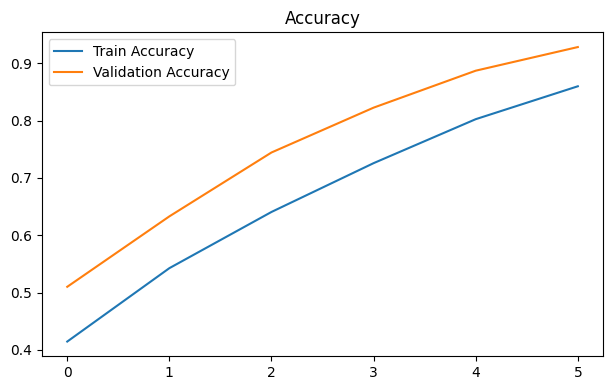

In [113]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')


plt.tight_layout()
plt.show()

# Loss

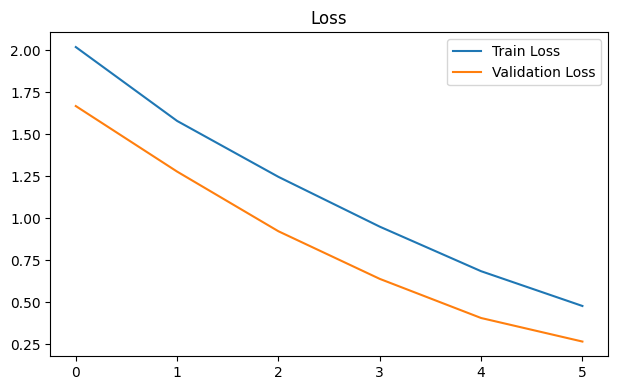

In [114]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()